In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Mounting Google Drive and Setting up dataset from Kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

# changing the working directory
%cd /content/gdrive/My Drive/Normalized

Mounted at /content/gdrive
/content/gdrive/My Drive/Normalized


# Importing required Libraries

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 40kB/s 


In [ ]:
!nvidia-smi

Sun Apr 18 14:16:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    77W / 149W |    124MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_path = "/content/gdrive/MyDrive/Normalized/train"
valid_path = "/content/gdrive/MyDrive/Normalized/test"

# Optimisation - Stochastic Gradient Descent with nesterov momentum
opt = SGD(lr = 0.0005, momentum = 0.9, nesterov = True)

# Image Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path, target_size = (150, 150), batch_size = 16, class_mode = 'categorical')

Found 38478 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(valid_path, target_size = (150, 150), batch_size = 16, class_mode = 'categorical') # shuffle = False

Found 9618 images belonging to 2 classes.


# Functions

In [ ]:
def set_untrainable(model):
  for layer in model.layers[:-3]:
    layer.trainable = False

def build_model(model):
  # add average global pooling layer, 1 fully connected layer, and a sigmoid classifier
  gap = GlobalAveragePooling2D()(model.layers[-5].output)
  fcl = Dense(2, activation = 'softmax')(gap)

  # define new model
  model = Model(inputs = model.inputs, outputs = fcl)

  set_untrainable(model)
  return model

def cm_cr(model):
  global test_set, training_set
  test_set.reset()
  Y_pred = model.predict(test_set, len(test_set) // 16 + 1)
  y_pred = np.argmax(Y_pred, axis = 1)
  print("Confusion Matrix")
  print(confusion_matrix(test_set.classes, y_pred))
  
  print("Classification Report")
  target_names = list(training_set.class_indices.keys())
  print(classification_report(test_set.classes, y_pred, target_names = target_names))

def classify(image, model):
  plt.figure(figsize = (2, 2))
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  plt.imshow(image)
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  pred = model.predict(image)
  if pred[0][0] > pred[0][1]:
    print("0 --> Non IDC")
  else:
    print("1 --> IDC")

In [ ]:
%cd /content/gdrive/My Drive/savedModels

/content/gdrive/My Drive/savedModels


# InceptionV3

In [ ]:
inception = InceptionV3(input_shape = (150, 150, 3), weights = 'imagenet', include_top = False)
inception = build_model(inception)
inception.summary()

# Accuracy must be at least 88%

In [ ]:
# Checkpoint and Early Stopping
mcp_save = ModelCheckpoint('inception', save_best_only = True, monitor = 'val_accuracy', mode = 'max')
early_stopping_monitor = EarlyStopping(monitor = 'val_accuracy', mode = 'max', restore_best_weights = True, patience = 5)

In [ ]:
# RUNNING FIRST TIME
inception.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

h = inception.fit(training_set, validation_data = test_set, epochs = 100, steps_per_epoch = len(training_set) // 16, 
                  validation_steps = len(test_set) // 16, callbacks=[mcp_save, early_stopping_monitor])

In [ ]:
# RUNNING SECOND TIME ONWARDS
inception = load_model('inception')
set_untrainable(inception)

h = inception.fit(training_set, validation_data = test_set, epochs = 46, steps_per_epoch = len(training_set) // 16, 
                  validation_steps = len(test_set) // 16, callbacks=[mcp_save, early_stopping_monitor])

# Confusion Matrix And Classification Report

In [ ]:
cm_cr(inception)

Confusion Matrix
[[4257  552]
 [ 797 4012]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      4809
           1       0.88      0.83      0.86      4809

    accuracy                           0.86      9618
   macro avg       0.86      0.86      0.86      9618
weighted avg       0.86      0.86      0.86      9618



In [ ]:
inception.evaluate(test_set)

602/602 [==============================] - 21s 33ms/step - loss: 0.3347 - accuracy: 0.8597


[0.33465445041656494, 0.8597421646118164]

# Making Predictions

In [ ]:
%cd /content/gdrive/My Drive/Normalized/test/0

/content/gdrive/My Drive/Normalized/test/1


0 --> Non IDC


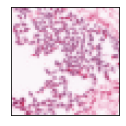

In [ ]:
image = load_img('12884_idx5_x2451_y501_class0.png', target_size = (150, 150))
classify(image, inception)

0 --> Non IDC


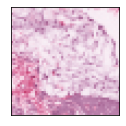

In [ ]:
image = load_img('12884_idx5_x2451_y701_class0.png', target_size = (150, 150))
classify(image, inception)

In [ ]:
%cd /content/gdrive/My Drive/Normalized/test/1

/content/gdrive/My Drive/Normalized/test/1


1 --> IDC


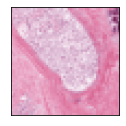

In [ ]:
image = load_img('12882_idx5_x1601_y301_class1.png', target_size = (150, 150))
classify(image, inception)

1 --> IDC


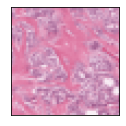

In [ ]:
image = load_img('12822_idx5_x1351_y501_class1.png', target_size = (150, 150))
classify(image, inception)